# Upload CSV

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


# Preprocess Data

In [ ]:
import pandas as pd
import numpy as np

stride = 16
wnd_size = 32 # default 32


hlt = [0.028565500784550377, 0.04393693362340742, 0.06572852861653047, 0.0956344448325386, 0.1353352832366127, 0.1862704636977009, 0.24935220877729622, 0.32465246735834974, 0.41111229050718745, 0.5063356166481006, 0.6065306597126334, 0.7066482778577162, 0.8007374029168081, 0.8824969025845955, 0.9459594689067654, 0.9862071167439163, 1.0, 0.9862071167439163, 0.9459594689067654, 0.8824969025845955, 0.8007374029168081, 0.7066482778577162, 0.6065306597126334, 0.5063356166481006, 0.41111229050718745, 0.32465246735834974, 0.24935220877729622, 0.1862704636977009, 0.1353352832366127, 0.0956344448325386, 0.06572852861653047, 0.04393693362340742]
hlt = np.array(hlt)

def window_stack(a, stepsize=1, width=3):
  n = a.shape[0]
  return np.hstack(a[i:1+n+i-width:stepsize] for i in range(0, width))

def read_csv(csv_file, fields, doDP, eps = 1.0):
    df = pd.read_csv(csv_file, usecols=fields)

    df_np = df.to_numpy()

    # first, split data by time-intervals
    df_np_split = np.split(df_np, np.where(df_np[:, 5] == 1)[0][1:], axis=0)
    df_wnd_lst = [];

    if(doDP):
        for i in df_np_split:
            for j in range(5):
                each_data = i[:,j]

                mindata = min(each_data)
                maxdata = max(each_data)

                GF = 10*(maxdata - mindata) / np.mean(each_data)
                #GF = 3*np.std(each_data) / np.mean(each_data)
                #GF = (maxdata - mindata) / math.sqrt((maxdata + mindata)/2)
                
                noise = np.random.laplace(0, GF / eps, each_data.shape)
                i[:,j] = each_data + noise
    # then, in each time-intervals, split by window size, jump by stride
    for i in df_np_split:
        # stride, wnd_size
        wnd = window_stack(i, stride, wnd_size)
        wnd = wnd.reshape(wnd.shape[0], wnd_size, 7)
        # wnd = np.append(wnd[:, :, :5] * hlt[:, np.newaxis], wnd[:, :, 5:], axis=2)
        df_wnd_lst.append(wnd)

    return df_wnd_lst

csv_file =  "train_data.csv"
fields = ['Engine_Idel_Target_Speed', 'Torque_converter_speed',
          'Transmission_oil_temperature', 'Wheel_velocity_rear_left-hand',
          'Torque_converter_turbine_speed_-_Unfiltered', 'Time(s)', 'Driver']

df_wnd_lst1 = read_csv('train_data.csv',fields,doDP=False) #train data를 DP없이 읽음.
df_wnd_lst2 = read_csv('train_data.csv',fields,doDP=True,eps=0.5) # train data를 읽어서 DP처리
df_wnd_lst3 = read_csv('test_data.csv',fields,doDP=False) # test data를 읽음.

print(df_wnd_lst1[0][0][0])
print(df_wnd_lst2[0][0][0])
print(df_wnd_lst3[0][0][0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


[650 939.3 87 0.0 935.5 1 'A']
[646.6311581825881 928.4781601172524 86.49679432014715 57.588477072543895
 897.5857034833664 1 'A']
[630 1121.8 95 0.0 1136.0 1 'A']


# k-means Clustering (would not work if wnd_size!=32 ... for now)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

K = 100

# data = df_wnd_lst[0].reshape(df_wnd_lst[0].shape[0], 160)
def kmeans_cluster(df_wnd_lst):
    data_driver = {}
    kmeans_driver = {}

    # split data by drivers
    for data in df_wnd_lst:
        driver = data[0][0][6]
        if data_driver.get(driver) is None:
            data_driver[driver] = data
        else:
            data_driver[driver] = np.append(data_driver[driver], data, axis=0)

    # derive k-means for each of driver DB
    for driver, data in data_driver.items():
        data = data[:, :, :5]
        data = data.reshape(data.shape[0], 160)
        kmeans = KMeans(n_clusters=K, random_state=0).fit(data)
        kmeans_driver[driver] = kmeans

    return kmeans_driver

kmeans_driver1 = kmeans_cluster(df_wnd_lst1)
kmeans_driver2 = kmeans_cluster(df_wnd_lst2)
'''
for driver, data in data_driver.items():
  for i in range(5):
    cdata = data[:, :, i]
    cdata = cdata.reshape(cdata.shape[0], 32)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(cdata)
    if kmeans_driver.get(driver) is None:
      kmeans_driver[driver] = [kmeans]
    else:
      kmeans_driver[driver].append(kmeans)
'''

# kmeans_driver['A'].cluster_centers_

# kmeans = KMeans(n_clusters=K, random_state=0).fit(data)

# kmeans.cluster_centers_
# for prediction, kmeans.predict(arr)
# for cluster centers, kmeans.cluster_centers_
# for labels, lkmeans.labels_

'\nfor driver, data in data_driver.items():\n  for i in range(5):\n    cdata = data[:, :, i]\n    cdata = cdata.reshape(cdata.shape[0], 32)\n    kmeans = KMeans(n_clusters=K, random_state=0).fit(cdata)\n    if kmeans_driver.get(driver) is None:\n      kmeans_driver[driver] = [kmeans]\n    else:\n      kmeans_driver[driver].append(kmeans)\n'

# Restoration of driving traits

노이즈없이 :  [774.44444444 741.14444444  93.55555556   5.27777778 740.76666667]
노이즈 :  [779.68029494 669.87100436 100.24886864  44.76853478 712.5989693 ]


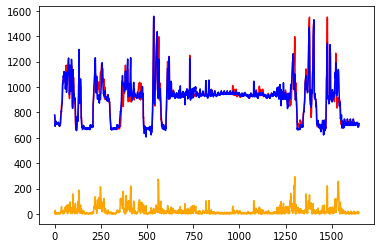

In [ ]:
import matplotlib.pyplot as plt

def restore(kmeans_driver,df_wnd_lst,driver='A'):
    kmeans = kmeans_driver[driver]
    test_pattern = df_wnd_lst[0]

    #print('실제값 : ',test_pattern[0][0][:5])
    reconst_pattern = np.empty((0, 32, 5))

    test_pattern = test_pattern[:, :, :5]
    test_pattern = test_pattern.reshape(test_pattern.shape[0], 32 * 5)
    labels = kmeans.predict(test_pattern)
    reconst_wnd = np.array([kmeans.cluster_centers_[i] for i in labels])
    reconst_wnd = reconst_wnd.reshape(reconst_wnd.shape[0], 32, 5)

    reconst_pattern_sum = np.zeros(((test_pattern.shape[0] - 1) * stride + wnd_size, 5))
    reconst_pattern_acc = np.zeros(((test_pattern.shape[0] - 1) * stride + wnd_size, 1))

    for i in range(reconst_wnd.shape[0]):
        for j in range(wnd_size):
            reconst_pattern_sum[stride * i + j] += reconst_wnd[i, j]
            reconst_pattern_acc[stride * i + j] += 1

    reconst_pattern = reconst_pattern_sum / reconst_pattern_acc 
    return reconst_pattern

reconst_pattern1 = restore(kmeans_driver1,df_wnd_lst1)
reconst_pattern2 = restore(kmeans_driver2,df_wnd_lst2)

print('노이즈없이 : ',reconst_pattern1[0])
print('노이즈 : ',reconst_pattern2[0])

err = abs(reconst_pattern1 - reconst_pattern2)
#print(err)
x = np.arange(len(err))

plt.plot(x,reconst_pattern1[:,0], color='red')
plt.plot(x,reconst_pattern2[:,0], color='blue')
plt.plot(x,err[:,0], color='orange')
plt.show()

# Classify using Random Forest (scikit is just divine)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

def classify(df_wnd_lst,df_wnd_lst2):
    all_data = None

    for data in df_wnd_lst:
        if all_data is None:
            all_data = data
        else:
            all_data = np.append(all_data, data, axis=0)

    rf_x = all_data[:, :, :5].reshape(all_data.shape[0], wnd_size * 5)
    rf_y = all_data[:, :, 6].reshape(all_data.shape[0], wnd_size)

    rf_x, rf_y = shuffle(rf_x, rf_y)

    rf_data_x = rf_x[:2000]
    rf_data_y = rf_y[:2000,0]
    all_data = None

    for data in df_wnd_lst2:
        if all_data is None:
            all_data = data
        else:
            all_data = np.append(all_data, data, axis=0)

    rf_x = all_data[:, :, :5].reshape(all_data.shape[0], wnd_size * 5)
    rf_y = all_data[:, :, 6].reshape(all_data.shape[0], wnd_size)

    rf_x, rf_y = shuffle(rf_x, rf_y)

    rf_test_x = rf_x[-500:]
    rf_test_y = rf_y[-500:,0]

    rf = RandomForestClassifier(n_estimators=100, oob_score=True)
    rf.fit(rf_data_x, rf_data_y)

    predicted = rf.predict(rf_test_x)
    accuracy = accuracy_score(rf_test_y, predicted)

    print('oob_score : ',rf.oob_score_)
    print('accuracy : ',accuracy)

print('Classify in NoDP')
classify(df_wnd_lst1,df_wnd_lst1)
print('Classify in DP')
classify(df_wnd_lst2,df_wnd_lst1)

Classify in NoDP
oob_score :  0.567
accuracy :  0.632
Classify in DP
oob_score :  0.5415
accuracy :  0.532
